In [12]:
# Description: Plot Figure 3 (Overview of wind, wave and density stratification during the field experiment).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from pandas import Timestamp
from xarray import open_dataset, DataArray
from dewaveADCP.utils import fourfilt

In [14]:
def fitN2(T, z, g=9.8, alpha=2e-4):
    fg = ~np.isnan(T)
    p = np.polyfit(z[fg], T[fg], 1)
    Tfit = np.polyval(p, z)
    dTdz = (Tfit[0] - Tfit[-1])/z.ptp()

    N = np.sqrt(g*alpha*np.abs(dTdz)) # [1/s].

    return N, Tfit

In [15]:
plt. close('all')

head = "../../data_reproduce_figs/"
ds = open_dataset(head+"windstress-wave-tide.nc")
twind = ds['twind'].values
twave = ds['twave'].values
ttide = ds['ttide'].values
taux, tauy = ds['taux'].values, ds['tauy'].values
Hs = ds['Hs'].values
Tp = ds['Tp'].values
meandir = ds['wavedir'].values
meandirspread = ds['wavespread'].values

In [16]:
# Low-pass filter wind stress.
dts_wind = 2*60 # 2 min sampling frequency.
Tmax = dts_wind*taux.size*2
Tmin = 60*60*30 # 30 h low-pass filter.
taux = fourfilt(taux, dts_wind, Tmax, Tmin)
tauy = fourfilt(tauy, dts_wind, Tmax, Tmin)


dsSIO = open_dataset(head+"windstress-SIOMiniMETBuoy.nc")
twindSIO = dsSIO['taux']['t']
tauxSIO, tauySIO = dsSIO['taux'].values, dsSIO['tauy'].values
dts_windSIO = 60*60 # 1 h averages.
tauxSIO = fourfilt(tauxSIO, dts_windSIO, Tmax, Tmin)
tauySIO = fourfilt(tauySIO, dts_windSIO, Tmax, Tmin)

tl, tr = Timestamp('2017-09-08'), Timestamp('2017-11-01')

$OC25M --> 1.46 \times 10^{-2}$ s$^{-1}$
$OC25SA --> 1.45 \times 10^{-2}$ s$^{-1}$
$OC25SB --> 1.42 \times 10^{-2}$ s$^{-1}$
$OC40S --> 1.25 \times 10^{-2}$ s$^{-1}$
$OC40N --> 1.20 \times 10^{-2}$ s$^{-1}$


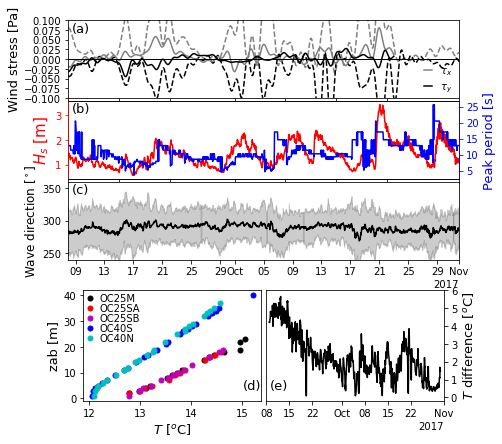

In [19]:
# Plot wind and wave variables.
shp = (4, 2)
fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot2grid(shp, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(shp, (1, 0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid(shp, (2, 0), colspan=2, rowspan=1)
ax4 = plt.subplot2grid(shp, (3, 0), colspan=1, rowspan=1) # T profiles from different moorings.
ax5 = plt.subplot2grid(shp, (3, 1), colspan=1, rowspan=1) # Top-bottom temperature difference.

ax1.plot(twindSIO, tauxSIO, color='gray', linestyle='--')
ax1.plot(twindSIO, tauySIO, color='k', linestyle='--')
ax1.plot(twind, taux, color='gray', label=r"$\tau_x$")
ax1.plot(twind, tauy, color='k', label=r"$\tau_y$")
ax1.axhline(color='k', linewidth=1)
ax1.set_ylabel('Wind stress [Pa]', fontsize=13)
ax1.legend(frameon=False, loc=(0.9, -0.01), handlelength=0.8)
ax1.set_ylim(-0.1, 0.1)

ax2.plot(twave, Hs, 'r', label=r'$H_s$')
ax2r = ax2.twinx()
ax2r.plot(twave, Tp, 'b', label=r'$T_p$')
ax2.set_ylabel(r'$H_s$ [m]', fontsize=15, color='r')
ax2r.set_ylabel(r'Peak period [s]', fontsize=13, color='b')
ax2r.spines['right'].set_color('b')
ax2r.spines['left'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ax2r.tick_params(axis='y', colors='b')

ax3.fill_between(twave, meandir-meandirspread, meandir+meandirspread, color='k', alpha=0.2)
ax3.plot(twave, meandir, 'k')
ax3.set_ylim(240, 360)
ax3.set_ylabel(r'Wave direction [$^\circ$]', fontsize=12)

ax1.xaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])
ax1.set_xlim(tl, tr)
ax2.set_xlim(tl, tr)
ax3.set_xlim(tl, tr)
fig.subplots_adjust(hspace=0.3)
ax2.axes.xaxis.set_tick_params(rotation=10)

ax1.text(0.01, 0.85, r'(a)', fontsize=13, transform=ax1.transAxes)
ax2.text(0.01, 0.85, r'(b)', fontsize=13, transform=ax2.transAxes)
ax3.text(0.01, 0.85, r'(c)', fontsize=13, transform=ax3.transAxes)


bbox = ax2.get_position()
offset = 0.04
ax2.set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

bbox = ax3.get_position()
offset = 0.08
ax3.set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])


locator = mdates.AutoDateLocator(minticks=12, maxticks=24)
fmts = ['', '%Y', '%Y', '%Y', '%Y', '%Y %H:%M']
formatter = mdates.ConciseDateFormatter(locator, offset_formats=fmts)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)

# Panel with all T profiles.
wanted_ids = ['OC25M', 'OC25SA', 'OC25SB', 'OC40S', 'OC40N']

col = dict(OC25M='k', OC25SA='r', OC25SB='m', OC40S='b', OC40N='c')
for id in wanted_ids:
    ds = open_dataset(head+"Tmean-"+id+".nc")
    T, zab = ds["Tmean"].values, ds["z"].values
    ax4.plot(T, zab, linestyle='none', marker='o', ms=5, mfc=col[id], mec=col[id], label=id)
ax4.legend(loc='upper left', bbox_to_anchor=(-0.05, 1.02), frameon=False, fontsize=10, labelspacing=0.01, handletextpad=0, borderpad=0, bbox_transform=ax4.transAxes)
ax4.set_xlabel(r'$T$ [$^o$C]', fontsize=13)
ax4.set_ylabel(r'zab [m]', fontsize=13)

# Fit a line to each mooring to estimate N2.
Navg = 0
for id in wanted_ids:
    ds = open_dataset(head+"Tmean-"+id+".nc")
    T, zab = ds["Tmean"].values, ds["z"].values
    N, Tfit = fitN2(T, zab)
    txt = r"$%s --> %.2f \times 10^{-2}$ s$^{-1}$"%(id, N*100)
    print(txt)
    Navg += N
Navg /= len(wanted_ids)

# Time series of top-to-bottom T difference.
Tstrat = open_dataset(head+"Tstrat-OC25M.nc")
Tstrat, tt = Tstrat["Tstrat"].values, Tstrat["t"].values
ax5.plot(tt, Tstrat, 'k')
ax1.yaxis.set_ticks([-0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1])
ax2r.yaxis.set_ticks([5, 10, 15, 20, 25])
ax4.yaxis.set_ticks([0, 10, 20, 30, 40])
ax5.yaxis.set_ticks(np.arange(7))

ax5.set_xlim(tl, tr)
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ax5.set_ylabel(r'$T$ difference [$^o$C]', fontsize=13)


locator = mdates.AutoDateLocator()
fmts = ['', '%Y', '%Y', '%Y', '%Y', '%Y %H:%M']
formatter = mdates.ConciseDateFormatter(locator, offset_formats=fmts)
ax5.xaxis.set_major_locator(locator)
ax5.xaxis.set_major_formatter(formatter)



ax4.text(0.90, 0.1, '(d)', fontsize=13, transform=ax4.transAxes)
ax5.text(0.02, 0.1, '(e)', fontsize=13, transform=ax5.transAxes)


offsetx = 0.03
offsety = 0.065
bbox = ax4.get_position()
ax4.set_position([bbox.x0 + offsetx, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 + offsety])

bbox = ax5.get_position()
ax5.set_position([bbox.x0 - offsetx, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0 + offsety])

In [18]:
plt.show()
fig.savefig("fig03.png", dpi=300, bbox_inches='tight')